# Market Mix Analysis (Introduction to Regression Analysis)

# Preface: 
- ***Im a Data Enthusiast, still learning and developing. Would appreciate your support by upvoting and comment your suggestion and feel free to correct me whereever Im wrong. Wrote this to help out anyone who is starting getting started with marketing mix modeling like me***

## Overview
Develop a MMM to to segregate the data


#### Outline
* [1: Data Preperation](#1)
    * [1.1: Dealing with Nan values](#1.1)
* [2: Exploratory Analysis](#2)
    * [2.2: Summary Statistics](#2.2)
    * [2.2: Correlation](#2.2)
    * [2.3: Continious Variables](#2.3)
    * [2.4: Categorical Variables](#2.4)
    * [2.5: Collinearity Test](#2.5)
* [3: Model Building](#4)
* [4: Analysis](#5)

In [125]:
# Basic Libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

# ML libraries
import sklearn
from sklearn import preprocessing

# Statsmodels
import statsmodels.api as sm
import statsmodels.tsa as tsa
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import abline_plot

import ipywidgets as widgets
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

<a id="1"></a> <br>
## Import Data

In [2]:
# Read Data
data = pd.read_csv("./marketingmixData.csv")

In [3]:
# strip extra spaces in header
data.columns = [i.strip() for i in data.columns]

In [4]:
# Check Data
print("number of rows: {}".format(len(data)))
data.head()

number of rows: 104


,NewVolSales,Base_Price,Radio,InStore,NewspaperInserts,Discount,TV,Stout,Website_Campaign
0,19564,15.029276,245.0,15.452,NaN,0.000,101.780000,2.28342,NaN
1,19387,15.029276,314.0,16.388,NaN,0.000,76.734000,2.22134,NaN
2,23889,14.585093,324.0,62.692,NaN,0.050,131.590200,2.00604,NaN
3,20055,15.332887,298.0,16.573,NaN,0.000,119.627060,2.19897,NaN
4,20064,15.642632,279.0,41.504,NaN,0.045,103.438118,1.81860,NaN


<a id="1.1"></a> <br>
### Dealing with Nan Values

In [5]:
data.isna().sum()

NewVolSales          0
Base_Price           0
Radio                4
InStore              0
NewspaperInserts    98
Discount             0
TV                   0
Stout                0
Website_Campaign    90
dtype: int64

There is a large amount of nan variables for Website Campaign and NewspaperInserts. <br />
Radio only has 4 empty variables

In [6]:
print(data.NewspaperInserts.value_counts())
print(data.Website_Campaign.value_counts())

Insert    6
Name: NewspaperInserts, dtype: int64
Website Campaign     6
Twitter              4
Facebook             4
Name: Website_Campaign, dtype: int64


NewspaperInserts can just be treated as a categorical variable.

In [7]:
data["NewspaperInserts"] = data["NewspaperInserts"].apply(lambda x: 0 if pd.isnull(x) else 1)

For Website Campaign data, since there are 3 variables present which are Website Campaign, Twitter and Facebook, we will be one-hot encoding these variables. the table below shows an example of what it will look like. <br />

| Website_Campaign | Website_Campaign | Twitter | Facebook |
|----------|----------|:-------------:|------:|
| Facebook | 0 |  0 | 1 |
| Website_Campaign | 1|    0  |  0 |
| Twitter | 0 | 1|   0 |

In [8]:
# One Hot Encode Website Campaign Data
data = pd.merge(data, pd.get_dummies(data["Website_Campaign"]), left_index=True, right_index=True)

In [9]:
# Change intial website to categorical variables
data.drop(columns=["Website_Campaign"], inplace=True)

Radio has 4 missing values, replacing this with 0 would work

In [10]:
data.fillna(0, inplace=True)

<a id="2"></a> <br>
## 2 : Exploratory Analysis

Here the goal is to explore the data and its different relationships with NewVolSales. We can visually try to ascertain which independent variables will have a strong effect on the dependent variable.

<a id="2.1"></a> <br>
### 2.1 Summary Statistics

In [11]:
data.describe()

,NewVolSales,Base_Price,Radio,InStore,NewspaperInserts,Discount,TV,Stout,Facebook,Twitter,Website Campaign
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,20171.067308,15.306740,246.817308,32.918567,0.057692,0.022059,141.009774,2.545966,0.038462,0.038462,0.057692
std,1578.604670,0.528902,98.663965,13.682570,0.234290,0.027668,42.949231,0.310070,0.193239,0.193239,0.234290
min,17431.000000,13.735724,0.000000,10.782000,0.000000,0.000000,37.656174,1.818600,0.000000,0.000000,0.000000
25%,19048.750000,15.029276,223.250000,22.183750,0.000000,0.000000,117.108343,2.316450,0.000000,0.000000,0.000000
50%,19943.500000,15.332887,276.000000,31.161500,0.000000,0.000000,138.581542,2.502120,0.000000,0.000000,0.000000
75%,20942.750000,15.642632,312.250000,41.079000,0.000000,0.049423,175.681780,2.814315,0.000000,0.000000,0.000000
max,24944.000000,16.281020,399.000000,68.119000,1.000000,0.090763,240.291967,3.158620,1.000000,1.000000,1.000000


<a id="2.2"></a> <br>
### 2.2 Correlation

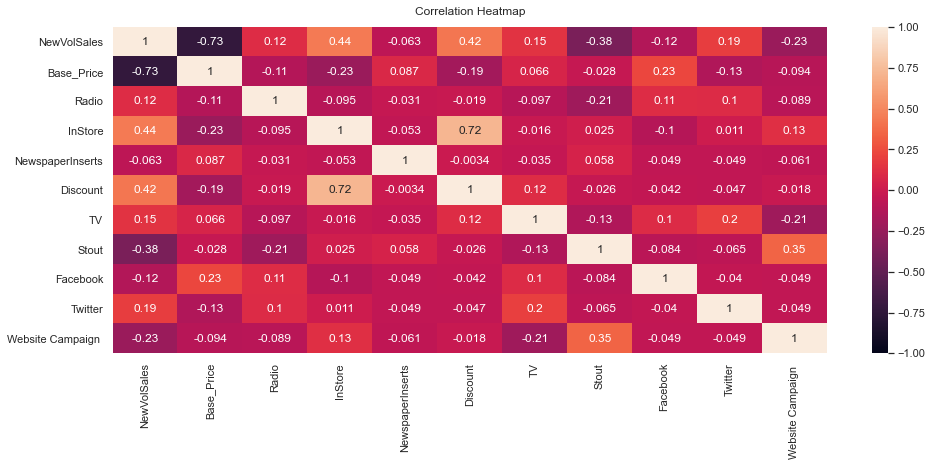

In [12]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

<a id="2.3"></a> <br>
### 2.3 Continious Variables

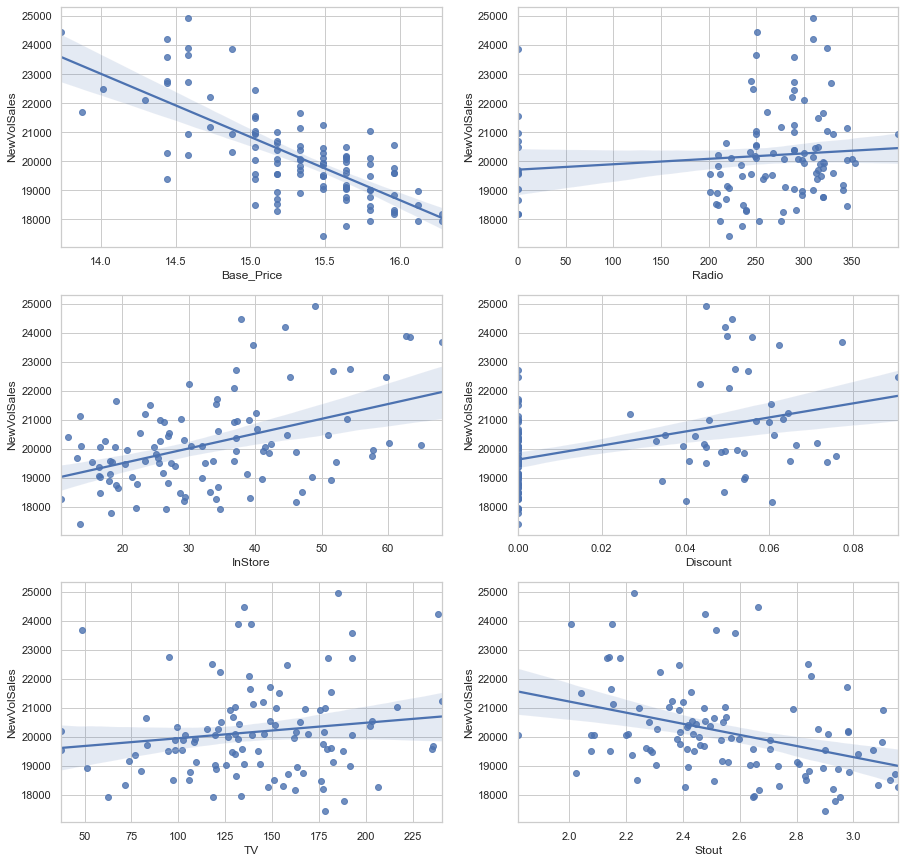

In [13]:
cols = ['Base_Price', 'Radio', 'InStore', 'Discount', 'TV', 'Stout']
n_rows, n_cols = 3, 2
fig_count = 0
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15,15))
for row_idx in range(n_rows):
    for col_idx in range(n_cols):

        sns.regplot(x=cols[fig_count], y='NewVolSales', data=data, ax=axs[row_idx][col_idx])
        fig_count += 1

Seemingly weak linear line fit with TV.

<a id="2.4"></a> <br>
### 2.4 Categorical Variables

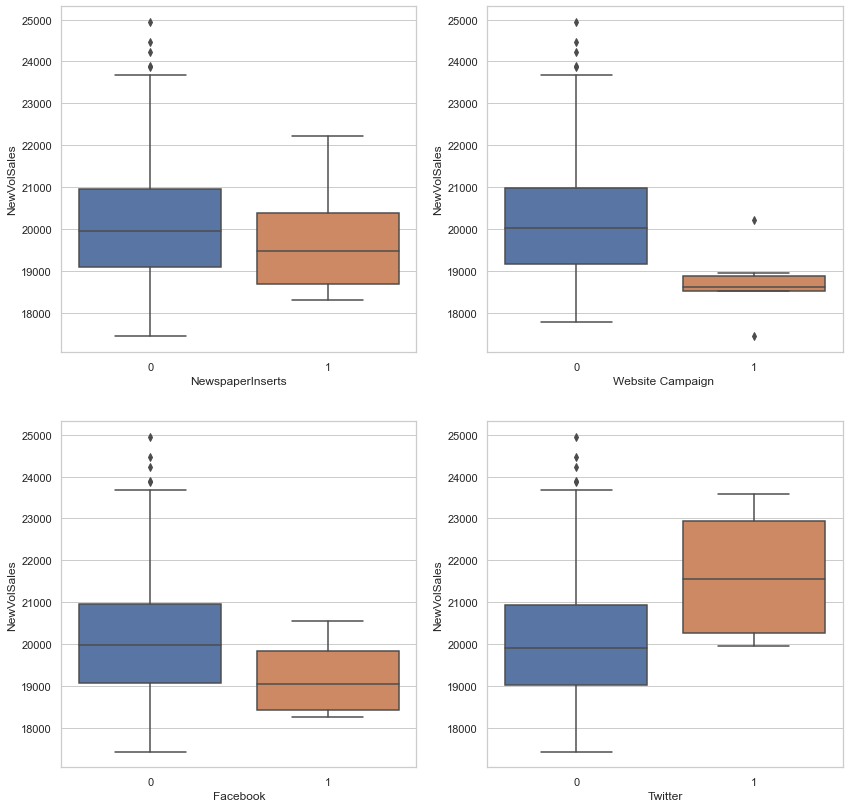

In [14]:
cols = ['NewspaperInserts', 'Website Campaign ', 'Facebook', 'Twitter',]

n_rows, n_cols = 2, 2
fig_count = 0
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols,  figsize=(14,14))
# Draw a nested boxplot to show bills by day and time
for row_idx in range(n_rows):
    for col_idx in range(n_cols):
        sns.boxplot(x=cols[fig_count], y='NewVolSales', data=data, ax=axs[row_idx][col_idx])
        fig_count += 1

only twitter campaigns and advertisments seem to have any positive impact on sales. Making a call that other variables will probably be very weak regressors

<a id="2.5"></a> <br>
### 2.5 Collinearity Test

In [15]:
X = data.drop(columns=["NewVolSales"]).copy()

X = X.assign(const=1)

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

              feature          VIF
0          Base_Price     1.174707
1               Radio     1.137035
2             InStore     2.290832
3    NewspaperInserts     1.029416
4            Discount     2.249350
5                  TV     1.179021
6               Stout     1.201498
7            Facebook     1.102337
8             Twitter     1.104352
9   Website Campaign      1.225918
10              const  1176.880121


Collinearity test is giving us all green, all variables seem to be below the standard of 2.5.

<a id="4"></a> <br>
## 3 : Modeling

<a id="3.1"></a> <br>
### 3.1 Random Forest (Feature Importance)

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
X_train, X_valid, y_train, y_valid = train_test_split(data.drop(columns=["NewVolSales"]), 
                                                      data[["NewVolSales"]],
                                                      test_size = 0.8, 
                                                      random_state = 42)

In [57]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf.fit(X_train, y_train)

print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, y_train), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(X_valid, y_valid)))

R^2 Training Score: 0.92 
OOB Score: 0.41 
R^2 Validation Score: 0.50


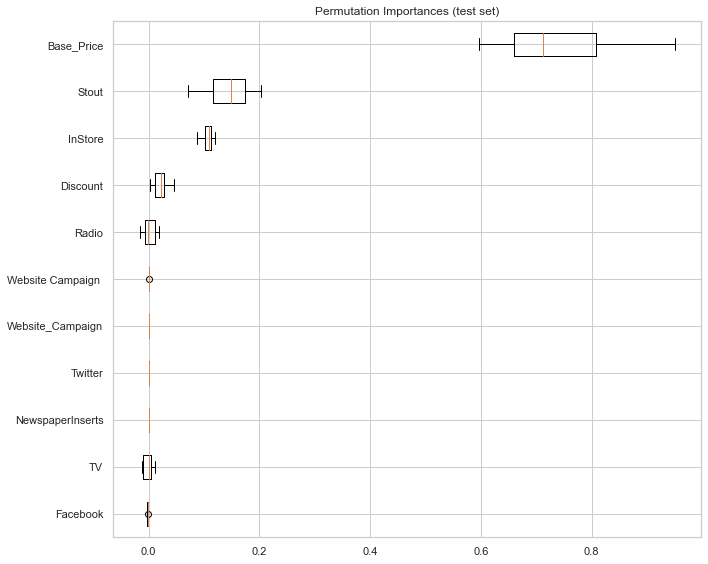

In [59]:
result = permutation_importance(rf, X_valid, y_valid, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10, 8))
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_valid.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

### 3.2 Linear regression

##### 3.2.1 Fulfilling Assumptions


In [170]:
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.stattools import durbin_watson

In [162]:
X = data.drop(columns=["NewVolSales"])
y = data[["NewVolSales"]]

lr = LinearRegression()
lr.fit(X, y)
output = lr.predict(X)

df_results = pd.DataFrame({'Actual': y.values.squeeze(), 
                           'Predicted': output.squeeze()})

df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])


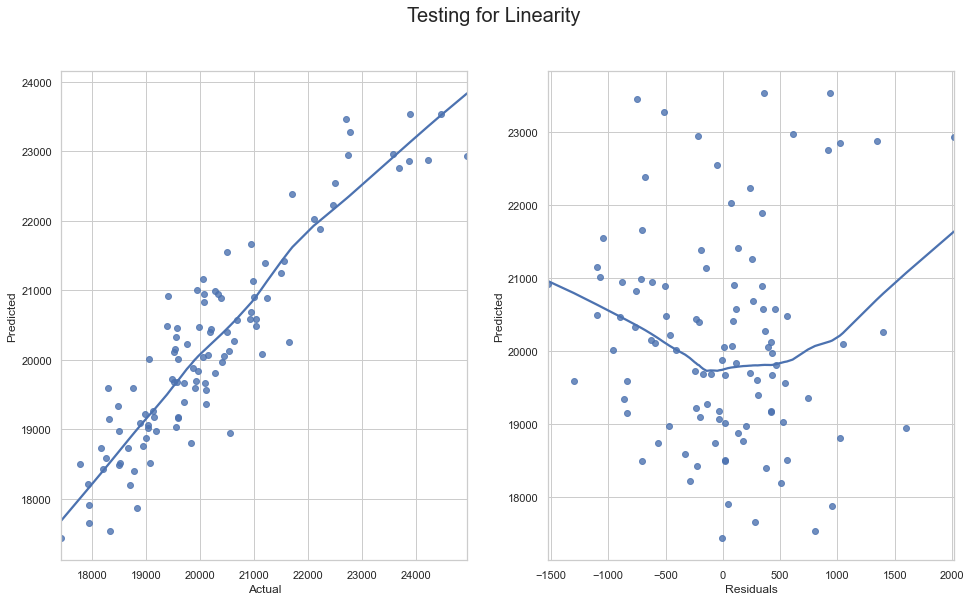

In [163]:
# Checking for Linearity
fig, ax = plt.subplots(1,2, figsize=(16,9))
fig.suptitle('Testing for Linearity', fontsize=20)

# Plotting the actual vs predicted values
sns.regplot(x='Actual', y='Predicted', data=df_results, lowess=True, fit_reg=True, ax=ax[0])

sns.regplot(x='Residuals', y='Predicted', data=df_results, lowess=True, fit_reg=True, ax=ax[1])
fig.show()

In [164]:
# check for normal errors

p-value from the test - below 0.05 generally means non-normal: 0.29762499500869144


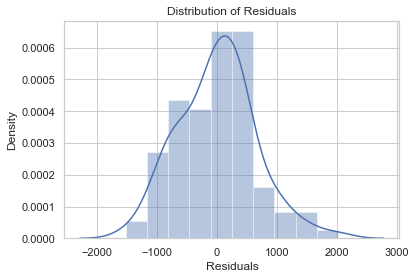

Residuals are normally distributed


In [168]:
p_value = normal_ad(df_results['Residuals'])[1]
print('p-value from the test - below 0.05 generally means non-normal:', p_value)

plt.title('Distribution of Residuals')
sns.distplot(df_results['Residuals'])
plt.show()
# Reporting the normality of the residuals
if p_value < 0.05:
    print('Residuals are not normally distributed')
else:
    print('Residuals are normally distributed')

In [175]:
print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
print('-------------------------------------')
durbinWatson = durbin_watson(df_results['Residuals'])

print(durbinWatson)

Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
-------------------------------------
1.4997577688720076


In [ ]:
def autocorrelation_assumption(model, features, label):
    """
    Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                     autocorrelation, then there is a pattern that is not explained due to
                     the current value being dependent on the previous value.
                     This may be resolved by adding a lag variable of either the dependent
                     variable or some of the predictors.
    """
    from statsmodels.stats.stattools import durbin_watson
    print('Assumption 4: No Autocorrelation', '\n')
    
    # Calculating residuals for the Durbin Watson-tests
    df_results = calculate_residuals(model, features, label)

    print('\nPerforming Durbin-Watson Test')
    print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
    print('-------------------------------------')
    durbinWatson = durbin_watson(df_results['Residuals'])
    print('Durbin-Watson:', durbinWatson)


Satisfying Linear Models assumptions.

Fit many linear models (One inital model is fitted against all, and the other models will excludes some variables) <br/>
The purpose is to measure how large an effect certain variables have in explaining the variance. <br/>

M1 : y = b0 + b1x1 + b2x2 + b3x3 <br/>
M2 : y = b0 + b1x1 + b2x2 <br/>
By comparing these two models, you can assess what is the percentage of variance that is explained by the x3 predictor

In [65]:
# Fit regression model (using the natural log of one of the regressors)
model_1 = smf.ols('NewVolSales ~ Base_Price + Discount + InStore + Stout  + (NewspaperInserts + Radio + TV + Facebook +  Twitter +  Website_Campaign )', data=data).fit()
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:            NewVolSales   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     46.63
Date:                Wed, 14 Jul 2021   Prob (F-statistic):           6.91e-32
Time:                        21:03:19   Log-Likelihood:                -819.66
No. Observations:                 104   AIC:                             1661.
Df Residuals:                      93   BIC:                             1690.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         5.439e+04   2278.795  

In [66]:
# Fit regression excluding controllable variables such as price and discount
model_2 =  smf.ols('NewVolSales ~ InStore + Stout + (NewspaperInserts + Radio + TV + Facebook +  Twitter +  Website_Campaign )', data=data).fit()

# Fit regression excluding advertising related data
model_3 = smf.ols('NewVolSales ~ Base_Price + Discount + InStore + Stout', data=data).fit()

<a id="5"></a> <br>
## 5 : Final Analysis

In [69]:
(model_3.rsquared - model_1.rsquared) / model_3.rsquared 

-0.06436156965078652

Advertising Factos are only accounting for only 4% of the variance behind the SALES

In [ ]:
For each predictor of which you want to assess the relative contribution, you need to specify two models. The first model contains all predictors that already figure in your regression model, and the second model is the same with the exception that it omits  the predictor of interest. For instance, 
M1 : y = b0 + b1x1 + b2x2 + b3x3
M2 : y = b0 + b1x1 + b2x2
By comparing these two models, you can assess what is the pourcentage of variance that is explained by the x3 predictor, when you include it in the model. Therefore, you can compute the PRE, Proportional Reductional of Error with the following equation : 
PRE = (Residual Sum of Squares of M2 - Residual Sum of Squares of M1) / Residual Sum of Squares of M2
The PRE represents the effect size of your predictor. In other words, it represents its unique contribution in pourcentages in explaining the variance of your dependent variable. 
Unfortunately, I do not know the way to do it in Matlab, yet I hope it gives you an idea on how you could proceed. 

In [143]:
(0.824-0.783) / 0.783

-0.040999999999999925